In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

In [13]:
# Define the cnn autoencoder model
def autoencoder(input_size):
    input_img = tf.keras.layers.Input(shape=(input_size, input_size, 1))  # adapt this if using `channels_first` image data format
    
    # Encoder
    x = tf.keras.layers.Conv2D(input_size, (3, 3), activation='relu', padding='same')(input_img)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    
    # Decoder
    # Decoder
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(input_size, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    return tf.keras.Model(input_img, decoded)

    
    return tf.keras.Model(input_img, decoded)


class DenoisingAutoencoder(tf.keras.Model):
    def __init__(self, input_size):
        super(DenoisingAutoencoder, self).__init__()
        self.model = autoencoder(input_size)

    def call(self, inputs, training=False):
        if training:
            # Add salt-and-pepper noise to the input data
            noise = tf.keras.backend.random_bernoulli(shape=tf.shape(inputs), p=0.3)
            inputs = inputs * noise
        # Call the model
        return self.model(inputs, training=training)

# Load and preprocess MNIST dataset

In [14]:
(x_train, _), (x_test, _) = mnist.load_data()
print(x_train.shape)
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((-1, 28, 28, 1))
x_test = x_test.reshape((-1, 28, 28, 1))

(60000, 28, 28)


# Create model

In [15]:
dae = DenoisingAutoencoder(x_train.shape[1])

# Compile model

In [16]:
dae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy')

# Train the model

In [17]:
history = dae.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True, validation_data=(x_test, x_test))
dae.summary()

Epoch 1/50


ValueError: in user code:

    File "C:\Users\User\miniconda3\envs\dae_sample\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\User\miniconda3\envs\dae_sample\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\User\miniconda3\envs\dae_sample\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\User\miniconda3\envs\dae_sample\lib\site-packages\keras\engine\training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\User\miniconda3\envs\dae_sample\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "C:\Users\User\miniconda3\envs\dae_sample\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\User\miniconda3\envs\dae_sample\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\User\miniconda3\envs\dae_sample\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\User\miniconda3\envs\dae_sample\lib\site-packages\keras\losses.py", line 2162, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "C:\Users\User\miniconda3\envs\dae_sample\lib\site-packages\keras\backend.py", line 5677, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 12, 12, 1) vs (None, 28, 28, 1)).


# Test the model

In [10]:
x_test_noisy = x_test + 0.3 * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
decoded_imgs = dae(x_test_noisy)

# Plotting histograms of activations

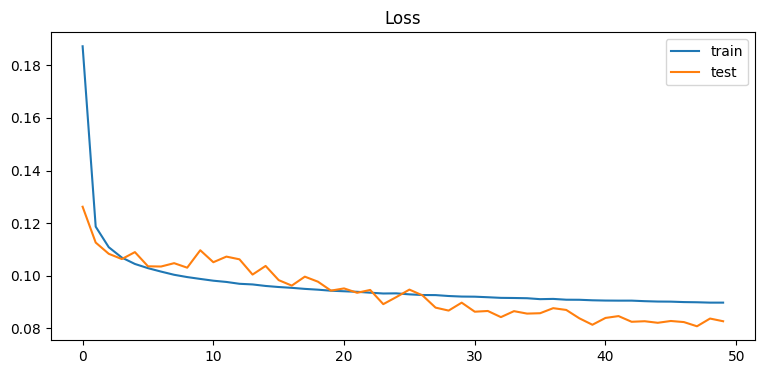

In [11]:
# plot histograms of val_loss and val_accuracy
plt.figure(figsize=(20, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Loss')
plt.legend()

# Plotting original and reconstructed images

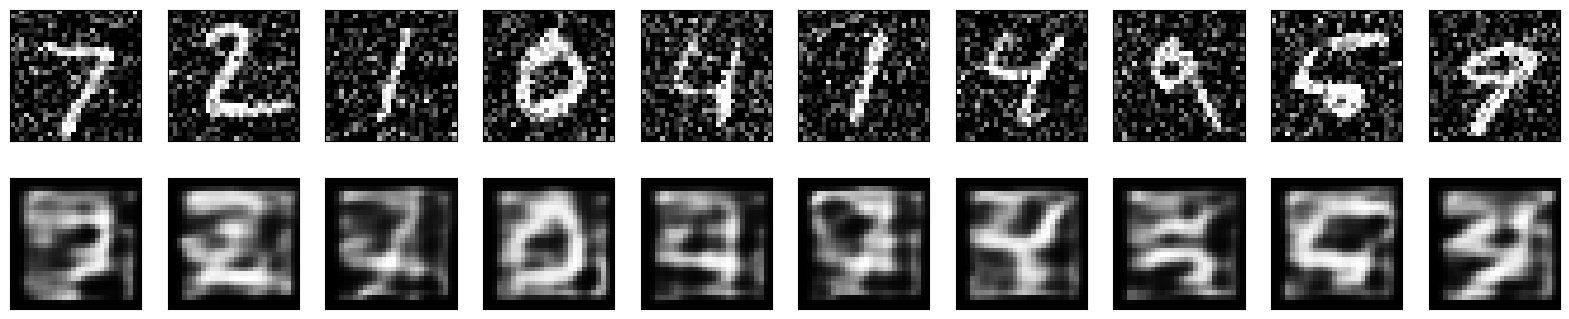

In [12]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()